In [ ]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import os
import sys
from PIL import Image
import time
import matplotlib.patches as mpatches

# indroot = '/media/senseable-beast/beast-brain-1/Data/streetviewdata/ind/'
# imgroot = '/media/senseable-beast/beast-brain-1/Data/streetviewdata/img2/'
# tgtroot = '/media/senseable-beast/beast-brain-1/Data/streetviewdata/img/'
indroot = 'C:/Users/lezhi/Dropbox/thesis/indfake/'
imgroot = 'C:/Users/lezhi/Dropbox/thesis/img2/'
tgtroot = 'C:/Users/lezhi/Dropbox/thesis/img/'

In [ ]:
image = Image.open(tgtroot+'london/51.45386,-0.138461068985_3.png') 
#  42.300131,-71.10339107_3  22.259156,114.200118326_1.png  22.266656,114.187148093_2.png  22.277156,114.170935302_1.png
# 22.278656,114.180662977_2  22.278656,114.166071465_0  22.278656,114.180662977_0  51.45386,-0.116771329008_1

imarr = np.array(image)
alpha = imarr[:, :, 3]
plt.imshow(alpha)

In [38]:
imarr.shape

(360L, 480L, 4L)

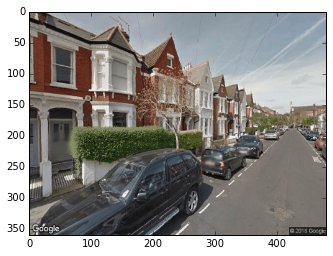

In [39]:
image = Image.fromarray(imarr[:,:,:3], 'RGB')
result = image.convert('P', palette=Image.ADAPTIVE, colors=256)
plt.imshow(result)

In [40]:
set(alpha.reshape(alpha.shape[0]*alpha.shape[1]))

{243, 244, 245, 246, 247, 248, 249, 250, 251, 252, 253, 254}

In [41]:
labels = ["Sky", "Building", "Pole", "Unlabelled", "Road", \
        "Pavement", "Tree", "SignSymbol", "Fence", \
        "Car", "Pedestrian", "Bicyclist"]

# def getmask(a, **kwargs):
#     inds = [labels.index(c)+243 for c in kwargs['category']]    
#     return [(ele in inds) for ele in np.nditer(a)]

# much better performance than the commented method...:
'''input a 2D index matrix, return a 2D boolean matrix 
where True means the pixel belongs to one of the specified "category".'''

def getmask(a, **kwargs):
    inds = [labels.index(c)+243 for c in kwargs['category']] 
    print np.array(inds)-243
    indicators = np.zeros((a.shape[0], a.shape[1], len(inds))).astype(np.uint8)
    for i in range(len(inds)):
        indicators[:,:,i] = np.array(np.squeeze([a==inds[i]]))
    return np.any(indicators, axis=2)

getmask(imarr[:,:,3], category=["Sky", "Building"]).shape

[0 1]


(360L, 480L)

In [42]:
mask = getmask(imarr[:,:,3], category=["Sky", "Building"])

[0 1]


[1 7 2]


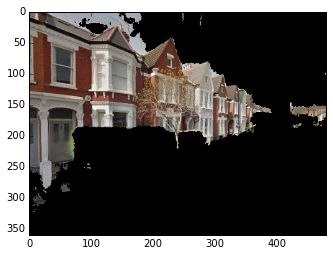

In [43]:
#["Bicyclist","Pedestrian", "Road", "Pavement","Car"]
# ["Building", "SignSymbol", "Pole"]
# ["Sky"]
# ["Tree"]
# ["SignSymbol"]

mask = getmask(imarr[:,:,3], category=["Building", "SignSymbol", "Pole"])
base = (0*np.ones((360,480,3))).astype(np.uint8)
base[mask] = (imarr[:,:,:3])[mask]
color_array = (imarr[:,:,:3])[mask]
plt.imshow(base)

In [44]:
import colorsys
colorsys.rgb_to_hls((4.27863777e-01,3.40557276e-01,2.94840041e-01))

TypeError: rgb_to_hls() takes exactly 3 arguments (1 given)

kmeans.cluster_centers_: [[ -9.15933995e-16  -1.11022302e-16   1.11022302e-15]
 [  5.70072239e-01   5.36119711e-01   4.98039216e-01]
 [  3.17394054e-01   3.01707780e-01   2.86780519e-01]
 [  7.55478662e-01   7.33794694e-01   7.12341407e-01]
 [  2.66013072e-01   1.46732026e-01   1.18300654e-01]
 [  5.20392157e-01   4.26274510e-01   3.45294118e-01]
 [  9.01960784e-01   8.90631808e-01   8.62309368e-01]
 [  6.98039216e-01   6.67079463e-01   6.29927761e-01]
 [  3.61689291e-01   1.46606335e-01   1.07390649e-01]
 [  1.34117647e-01   1.13464052e-01   1.01437908e-01]
 [  4.97698210e-01   4.82523444e-01   4.34441603e-01]
 [  4.03016591e-01   3.96983409e-01   3.87631976e-01]
 [  8.22657952e-01   8.13943355e-01   7.93899782e-01]
 [  4.07058824e-01   2.68235294e-01   2.14117647e-01]
 [  2.43921569e-01   2.31960784e-01   2.23725490e-01]
 [  7.04313725e-01   4.80784314e-01   3.46666667e-01]
 [  4.15468410e-01   3.65141612e-01   2.93028322e-01]
 [  6.17787115e-01   6.03641457e-01   5.80812325e-01]
 [ 

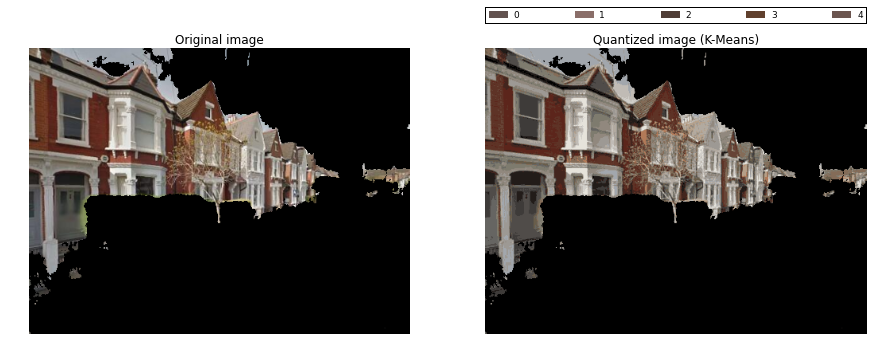

In [45]:
# http://scikit-learn.org/stable/auto_examples/cluster/plot_color_quantization.html

from sklearn.cluster import KMeans, MeanShift, estimate_bandwidth
from sklearn.metrics import pairwise_distances_argmin
from sklearn.datasets import load_sample_image
from sklearn.utils import shuffle

n_colors = 21

image = Image.fromarray(base, 'RGB')
# Dividing by 255 because plt.imshow need to be in the range [0-1]
image = np.array(image, dtype=np.float64) / 255

# transform to a 2D numpy array.
w, h, d = original_shape = tuple(image.shape)
assert d == 3
image_array = np.reshape(image, (w * h, d))
image_array_sample = shuffle(image_array, random_state=0)[:1000]
kmeans = KMeans(n_clusters=n_colors, random_state=0).fit(image_array_sample)

####################### Get labels for all points
labels = kmeans.predict(image_array)
#print "most frequent color:", kmeans.cluster_centers_[max([np.sum(labels == i) for i in range(len(kmeans.cluster_centers_))])]
# print max([np.sum(labels == i) for i in range(len(kmeans.cluster_centers_))])
print "kmeans.cluster_centers_:", kmeans.cluster_centers_

##################### Compute clustering with MeanShift
#X = np.array([list(colorsys.rgb_to_hls(c[0], c[1], c[2])) for c in kmeans.cluster_centers_ if (c[0]>0.01 and c[1]>0.01 and c[2]>0.01)])
X = np.array([list(colorsys.rgb_to_hls(c[0], c[1], c[2])) for c in kmeans.cluster_centers_])
X_s = np.array([i for i in X if i[2]>0.3 and i[1]>0.1])
print "X:", X
print "X_s:", X_s

def recreate_image(codebook, labels, w, h):
    """Recreate the (compressed) image from the code book & labels"""
    d = codebook.shape[1]
    image = np.zeros((w, h, d))
    label_idx = 0
    for i in range(w):
        for j in range(h):
            image[i][j] = codebook[labels[label_idx]]
            label_idx += 1
    return image

import matplotlib.patches as mpatches

# Display all results, alongside original image
plt.figure(figsize=(15, 6))
plt.subplot(121)
plt.axis('off')
plt.title('Original image')
plt.imshow(image)

plt.subplot(122)
plt.axis('off')
plt.title('Quantized image (K-Means)')
# new_cookbook = np.array([cluster_centers[i] for i in ms_labels])
new_cookbook = kmeans.cluster_centers_
plt.imshow(recreate_image(new_cookbook, labels, w, h))

lg_handles = []
lg_labels = []
def hex_to_rgb(value):
    value = value.lstrip('#')
    lv = len(value)
    
    return tuple(int(value[i:i + lv // 3], 16) for i in range(0, lv, lv // 3))
def rgb_to_hex(rgb):
    rgb_ = tuple(((np.array(rgb)*255).astype(np.uint8)))    
    return '#%02x%02x%02x' % rgb_

for i in range(len(X_s)):
    hexi = rgb_to_hex(tuple(colorsys.hsv_to_rgb(X_s[i][0], X_s[i][1], X_s[i][2])))
    rect = mpatches.Patch(color=hexi)
    lg_handles.append(rect)
    lg_labels.append(str(i))
plt.legend(lg_handles,lg_labels,bbox_to_anchor=(0. ,1.09 ,1.,0.3),loc=8,
           ncol=5,mode='expand',borderaxespad=0,prop={'size':9},numpoints=1)

In [71]:
[i[1] for i in dt_c]

[(0.025701858442071974, 0.23453996983408748, 0.54212218649517685),
 (0.03906062784567458, 0.26000000000000001, 0.41960784313725502)]

In [69]:
fq_c[1]

(0.088108882521489462, 0.53405572755417963, 0.077297895902547487)

In [70]:
X_s = [i[1] for i in dt_c].append((0.088108882521489462, 0.53405572755417963, 0.077297895902547487))
print 'X_s:', type(X_s)

X_s: <type 'NoneType'>


In [ ]:
# 22222222222222222222222222222222222
n_colors = 13

def not_black(hsv):
    #return not (rgb[0]<0.01 and rgb[1]<0.01 and rgb[2]<0.01)
    return hsv[2] > 0.01

image = Image.fromarray(base, 'RGB')
image = np.array(image, dtype=np.float64) / 255

# transform to a 2D numpy array.
w, h, d = original_shape = tuple(image.shape)
assert d == 3
image_array = np.reshape(image, (w * h, d))
image_array_sample = shuffle(image_array, random_state=0)[:1000]

################ predicting color using kmeans
# kmeans = KMeans(n_clusters=n_colors, random_state=0).fit(image_array_sample)
# labels = kmeans.predict(image_array)
# print "kmeans.cluster_centers_:", kmeans.cluster_centers_
# centers = kmeans.cluster_centers_

##################### Compute clustering with MeanShift
# The following bandwidth can be automatically detected using
bandwidth = estimate_bandwidth(image_array_sample, quantile=0.08)
ms = MeanShift(bandwidth=bandwidth, bin_seeding=True).fit(image_array_sample)
labels = ms.predict(image_array)
print "ms.cluster_centers_:", ms.cluster_centers_
labels_unique = np.unique(labels)
n_clusters = len(labels_unique)
print 'n_clusters:', n_clusters
centers = ms.cluster_centers_

centers_hsv = [colorsys.rgb_to_hsv(i[0],i[1],i[2]) for i in centers]

# tuples of index, color, number of pixels with that color
sum_info = [(i, centers_hsv[i], np.sum(labels == i)) for i in range(len(centers_hsv))]
non_black = [i for i in sum_info if not_black(i[1])]
fq_c = max(non_black , key=lambda s: s[1])
print "most frequent color:", fq_c

dt_c = sorted(non_black , key=lambda s: s[1][1], reverse=True)[:2]
print "most distinct color:", dt_c

X_s = [i[1] for i in dt_c] + [fq_c[1]]
print 'X_s:', type(X_s)

def recreate_image(codebook, labels, w, h):
    """Recreate the (compressed) image from the code book & labels"""
    d = codebook.shape[1]
    image = np.zeros((w, h, d))
    label_idx = 0
    for i in range(w):
        for j in range(h):
            image[i][j] = codebook[labels[label_idx]]
            label_idx += 1
    return image

print "labels:", np.unique(labels)

# Display all results, alongside original image
plt.figure(figsize=(15, 6))
plt.subplot(121)
plt.title('Original image')
plt.imshow(image)

plt.subplot(122)
plt.title('Quantized image (K-Means)')
# new_cookbook = np.array([cluster_centers[i] for i in ms_labels])
new_cookbook = centers
plt.imshow(recreate_image(new_cookbook, labels, w, h))

lg_handles = []
lg_labels = []
def hex_to_rgb(value):
    value = value.lstrip('#')
    lv = len(value)
    
    return tuple(int(value[i:i + lv // 3], 16) for i in range(0, lv, lv // 3))
def rgb_to_hex(rgb):
    rgb_ = tuple(((np.array(rgb)*255).astype(np.uint8))) 
    print '#%02x%02x%02x' % rgb_
    return '#%02x%02x%02x' % rgb_

for i in range(len(X_s)):
    hexi = rgb_to_hex(tuple(colorsys.hsv_to_rgb(X_s[i][0], X_s[i][1], X_s[i][2])))
    rect = mpatches.Patch(color=hexi)
    lg_handles.append(rect)
    lg_labels.append(str(i))
plt.legend(lg_handles,lg_labels,bbox_to_anchor=(0. ,1.09 ,1.,0.3),loc=8,
           ncol=5,mode='expand',borderaxespad=0,prop={'size':9},numpoints=1)

ms.cluster_centers_: [[ 0.          0.          0.        ]
 [ 0.55254902  0.53215686  0.50313725]
 [ 0.31602434  0.30196078  0.28695064]
 [ 0.65504202  0.65448179  0.65602241]
 [ 0.61932773  0.60308123  0.57857143]
 [ 0.36946779  0.17310924  0.13011204]
 [ 0.51027451  0.49521569  0.45835294]
 [ 0.25116713  0.24257703  0.23118581]
 [ 0.48169935  0.43093682  0.37429194]
 [ 0.40882353  0.34117647  0.29681373]
 [ 0.72401961  0.69166667  0.66176471]
 [ 0.4020915   0.39346405  0.3730719 ]
 [ 0.76711916  0.7387632   0.71221719]
 [ 0.14208145  0.12036199  0.10950226]
 [ 0.27486631  0.17005348  0.14581105]
 [ 0.31265597  0.23065954  0.19073084]
 [ 0.81960784  0.80980392  0.78941176]
 [ 0.38313725  0.27843137  0.24980392]
 [ 0.87102397  0.85315904  0.8291939 ]
 [ 0.27647059  0.1248366   0.08366013]
 [ 0.75294118  0.49150327  0.36601307]
 [ 0.61437908  0.46405229  0.31503268]
 [ 0.55555556  0.42352941  0.27189542]
 [ 0.51764706  0.56470588  0.37647059]
 [ 0.75686275  0.72156863  0.50588235]
 [ 0

ms_labels: [11  9  2 ...,  0  0  0] shape: (172800L,)
n_clusters: 26
ms.cluster_centers_: [[ 0.          0.          0.        ]
 [ 0.55254902  0.53215686  0.50313725]
 [ 0.31602434  0.30196078  0.28695064]
 [ 0.65504202  0.65448179  0.65602241]
 [ 0.61932773  0.60308123  0.57857143]
 [ 0.36946779  0.17310924  0.13011204]
 [ 0.51027451  0.49521569  0.45835294]
 [ 0.25116713  0.24257703  0.23118581]
 [ 0.48169935  0.43093682  0.37429194]
 [ 0.40882353  0.34117647  0.29681373]
 [ 0.72401961  0.69166667  0.66176471]
 [ 0.4020915   0.39346405  0.3730719 ]
 [ 0.76711916  0.7387632   0.71221719]
 [ 0.14208145  0.12036199  0.10950226]
 [ 0.27486631  0.17005348  0.14581105]
 [ 0.31265597  0.23065954  0.19073084]
 [ 0.81960784  0.80980392  0.78941176]
 [ 0.38313725  0.27843137  0.24980392]
 [ 0.87102397  0.85315904  0.8291939 ]
 [ 0.27647059  0.1248366   0.08366013]
 [ 0.75294118  0.49150327  0.36601307]
 [ 0.61437908  0.46405229  0.31503268]
 [ 0.55555556  0.42352941  0.27189542]
 [ 0.51764706

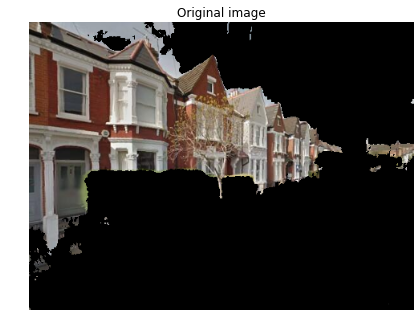

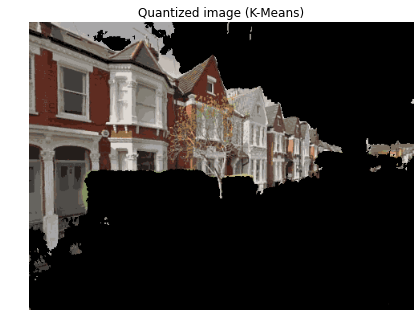

In [50]:
# 33333333333333333333333333

from sklearn.cluster import KMeans, MeanShift, estimate_bandwidth
from sklearn.metrics import pairwise_distances_argmin
from sklearn.datasets import load_sample_image
from sklearn.utils import shuffle

n_colors = 20

image = Image.fromarray(base, 'RGB')
# Dividing by 255 because plt.imshow need to be in the range [0-1]
image = np.array(image, dtype=np.float64) / 255

# transform to a 2D numpy array.
w, h, d = original_shape = tuple(image.shape)
assert d == 3
image_array = np.reshape(image, (w * h, d))
X = shuffle(image_array, random_state=0)[:1000]
#kmeans = KMeans(n_clusters=n_colors, random_state=0).fit(image_array_sample)

##################### Compute clustering with MeanShift
# The following bandwidth can be automatically detected using
bandwidth = estimate_bandwidth(X, quantile=0.08)

ms = MeanShift(bandwidth=bandwidth, bin_seeding=True)
ms.fit(X)
ms_labels = ms.predict(image_array)
print "ms_labels:", ms_labels, "shape:", ms_labels.shape

labels_unique = np.unique(ms_labels)
n_clusters = len(labels_unique)
print 'n_clusters:', n_clusters

####################### Get labels for all points

weight = 1

# def construct_hsv(c):
#     hsv_lst = list(colorsys.rgb_to_hls(c[0], c[1], c[2]))
#     return [weight*hsv_lst[0], hsv_lst[1], weight*hsv_lst[2]]

# def de_construct_hsv(c):
#     return list(colorsys.hls_to_rgb(c[0]/weight, c[1], c[2]/weight))

#ms_cluster_centers = np.array([construct_hsv(c) for c in ms.cluster_centers_])
print "ms.cluster_centers_:", ms.cluster_centers_

print("number of estimated clusters : %d" % n_clusters)

def recreate_image(codebook, labels, w, h):
    """Recreate the (compressed) image from the code book & labels"""
    d = codebook.shape[1]
    image = np.zeros((w, h, d))
    label_idx = 0
    for i in range(w):
        for j in range(h):
            image[i][j] = codebook[ms_labels[label_idx]]
            label_idx += 1
    return image

# Display all results, alongside original image
plt.figure(1)
plt.clf()
ax = plt.axes([0, 0, 1, 1])
plt.axis('off')
plt.title('Original image')
plt.imshow(image)

plt.figure(2)
plt.clf()
ax = plt.axes([0, 0, 1, 1])
plt.axis('off')
plt.title('Quantized image (K-Means)')
new_cookbook = ms.cluster_centers_
#new_cookbook = np.array([cluster_centers[i] for i in ms_labels])
#new_cookbook = kmeans.cluster_centers_
plt.imshow(recreate_image(new_cookbook, labels, w, h))


kmeans.cluster_centers_: [[ -9.15933995e-16  -1.11022302e-16   1.11022302e-15]
 [  5.65062389e-01   5.33214498e-01   4.92216280e-01]
 [  4.02111614e-01   2.81447964e-01   2.23831071e-01]
 [  7.01372549e-01   6.62352941e-01   6.03529412e-01]
 [  9.01960784e-01   8.90631808e-01   8.62309368e-01]
 [  5.25303455e-01   4.27824463e-01   3.44351074e-01]
 [  3.71936275e-01   1.88970588e-01   1.41299020e-01]
 [  1.34117647e-01   1.13464052e-01   1.01437908e-01]
 [  8.19607843e-01   8.09803922e-01   7.89411765e-01]
 [  2.24929972e-01   2.16806723e-01   2.16246499e-01]
 [  6.19860848e-01   5.91144845e-01   5.62934851e-01]
 [  7.38823529e-01   5.08235294e-01   3.75686275e-01]
 [  4.18627451e-01   3.68627451e-01   2.98529412e-01]
 [  7.50544662e-01   7.27450980e-01   7.05010893e-01]
 [  3.19444444e-01   3.06372549e-01   2.97712418e-01]
 [  6.40819964e-01   6.50623886e-01   6.67201426e-01]
 [  2.92401961e-01   1.40686275e-01   1.09313725e-01]
 [  4.03016591e-01   3.96983409e-01   3.87631976e-01]
 [ 

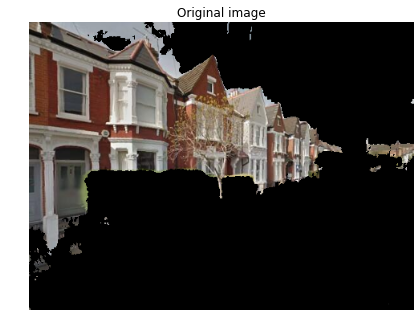

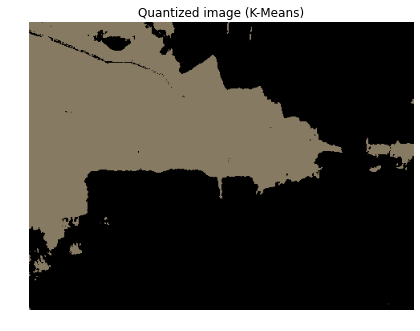

In [49]:
# 4444444444444444444444444

from sklearn.cluster import KMeans, MeanShift, estimate_bandwidth
from sklearn.metrics import pairwise_distances_argmin
from sklearn.datasets import load_sample_image
from sklearn.utils import shuffle

n_colors = 20

image = Image.fromarray(base, 'RGB')
# Dividing by 255 because plt.imshow need to be in the range [0-1]
image = np.array(image, dtype=np.float64) / 255

# transform to a 2D numpy array.
w, h, d = original_shape = tuple(image.shape)
assert d == 3
image_array = np.reshape(image, (w * h, d))
image_array_sample = shuffle(image_array, random_state=0)[:1000]
kmeans = KMeans(n_clusters=n_colors, random_state=0).fit(image_array_sample)

####################### Get labels for all points
labels = kmeans.predict(image_array)
#print "most frequent color:", kmeans.cluster_centers_[max([np.sum(labels == i) for i in range(len(kmeans.cluster_centers_))])]
# print max([np.sum(labels == i) for i in range(len(kmeans.cluster_centers_))])
print "kmeans.cluster_centers_:", kmeans.cluster_centers_

##################### Compute clustering with MeanShift
weight = 1

def construct_hsv(c):
    hsv_lst = list(colorsys.rgb_to_hls(c[0], c[1], c[2]))
    return [weight*hsv_lst[0], hsv_lst[1], weight*hsv_lst[2]]

def de_construct_hsv(c):
    return list(colorsys.hls_to_rgb(c[0]/weight, c[1], c[2]/weight))

X = np.array([construct_hsv(c) for c in kmeans.cluster_centers_])
# print "X:", X

# The following bandwidth can be automatically detected using
bandwidth = estimate_bandwidth(X, quantile=0.18)

ms = MeanShift(bandwidth=bandwidth, bin_seeding=True)
ms.fit(X)
ms_labels = ms.labels_
cluster_centers = np.array([de_construct_hsv(c) for c in ms.cluster_centers_])
print "ms_labels:", ms_labels
print "cluster_centers:", cluster_centers

labels_unique = np.unique(ms_labels)
n_clusters_ = len(labels_unique)

print("number of estimated clusters : %d" % n_clusters_)

def recreate_image(codebook, labels, w, h):
    """Recreate the (compressed) image from the code book & labels"""
    d = codebook.shape[1]
    image = np.zeros((w, h, d))
    label_idx = 0
    for i in range(w):
        for j in range(h):
            image[i][j] = codebook[labels[label_idx]]
            label_idx += 1
    return image

# Display all results, alongside original image
plt.figure(1)
plt.clf()
ax = plt.axes([0, 0, 1, 1])
plt.axis('off')
plt.title('Original image')
plt.imshow(image)

plt.figure(2)
plt.clf()
ax = plt.axes([0, 0, 1, 1])
plt.axis('off')
plt.title('Quantized image (K-Means)')
new_cookbook = np.array([cluster_centers[i] for i in ms_labels])
#new_cookbook = kmeans.cluster_centers_
plt.imshow(recreate_image(new_cookbook, labels, w, h))
